In [2]:
# 验证路径设置
import os
import sys

# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: /opt/anaconda3/envs/quant/bin/python
Project root: /Users/zhengyi/stock_project


[*********************100%***********************]  1 of 1 completed

✅ 模块导入成功！


In [3]:
# 下载股票数据
start_date = '2024-01-01'
end_date = '2025-04-01'
ticker = ['PDD']

df = download_stock_data( ticker , start_date , end_date )
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI
Date,,,,,,,,,,,,
2024-01-02,143.880005,145.690002,141.899994,145.639999,8211900,NaN,NaN,2.670901,NaN,NaN,NaN,NaN
2024-01-03,143.779999,150.369995,143.619995,148.949997,7504100,2.272726,0.022473,4.699903,NaN,NaN,NaN,NaN
2024-01-04,148.410004,150.190002,147.470001,147.740005,4435900,-0.812347,-0.008157,1.844444,NaN,NaN,NaN,NaN
2024-01-05,147.279999,148.940002,145.809998,146.529999,4394600,-0.819011,-0.008224,2.146633,NaN,NaN,NaN,NaN
2024-01-08,144.009995,147.979996,143.279999,147.550003,6195500,0.696106,0.006937,3.280288,NaN,NaN,NaN,NaN


/Users/zhengyi/stock_project/src/visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


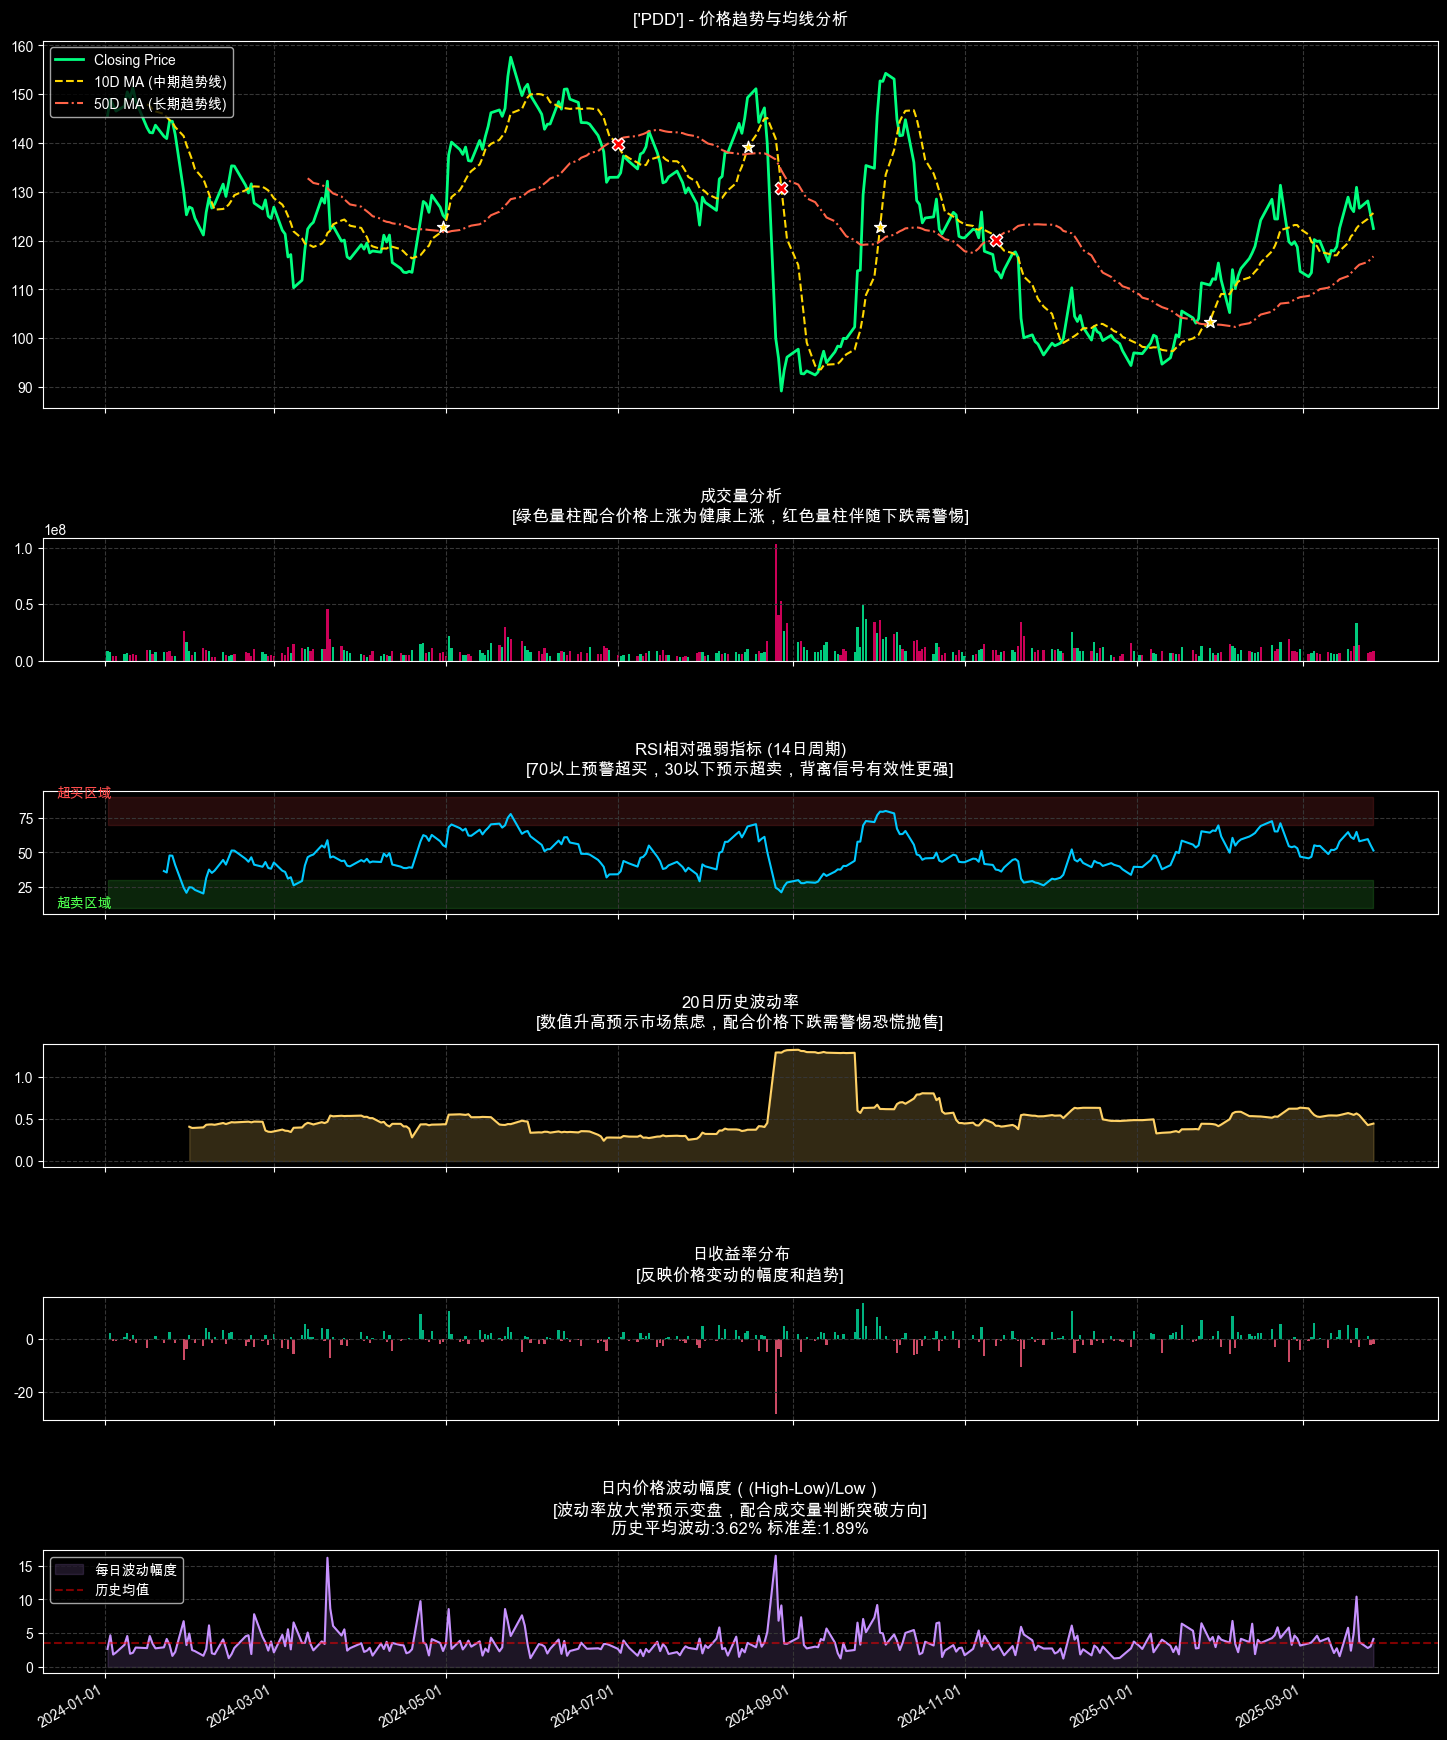

In [4]:
plot_technical(df,ticker)

In [45]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，我是金融小白，这是{ticker}从{start_date}到{end_date}的交易数据，
    请用简单专业的语言分析{ticker[0]}是否值得投资：
    {latest}
    """
    
    # 步骤3：调用Deepseek API并解析结果
    try:
        notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("/")[-2]
        project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
        client = OpenAI(
                api_key=os.environ.get("OPENAI_API_KEY"),
                base_url=os.getenv("DEEPSEEK_BASE_URL")
                )
        
        completion = client.chat.completions.create(
        model="deepseek-r1-250120",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 500,
        temperature = 0.7
        )
        # 解析响应
        response_message = completion.choices[0].message

        # 提取回答和思考内容
        answer = response_message.content
        reasoning = response_message.reasoning_content

        # 格式化输出，只显示回答，不显示思考
        formatted_output = f'回答：{answer.strip()}'

        # 打印结果
        return print(data_summary + "\n" + formatted_output)
        
    except Exception as e:
        print(f"模型调用失败: {str(e)}")
        return "暂无分析结果"

In [30]:
get_deepseek_analysis(df)

回答：以下是基于提供数据的PDD投资分析，以简明语言呈现关键点：

### 一、价格趋势
- **整体下跌**：股价从2024年初的145美元跌至2025年3月底的122美元，跌幅约16%，尤其在2025年3月加速下滑（月跌幅超6%），反映市场信心减弱。

### 二、技术指标信号
1. **均线矛盾**：
   - **短期金叉**：MA10（10日均线）上穿MA50（50日均线）形成“金叉”，传统上是买入信号。
   - **背离风险**：金叉后股价反而下跌，暗示技术信号可能失效，需警惕诱多陷阱。

2. **RSI中性偏弱**：最新RSI（51.39）接近50分界线，既未超卖（<30）也未超买（>70），方向指引有限。

3. **波动率攀升**：2025年3月波动率突破0.5（假设为年化波动率），股价震荡加剧，短期风险升高。

### 三、资金流动
- **放量下跌**：3月20日单日成交量激增至3,335万股（远超均量），当日虽收涨3.97%，但随后三日连续放量下跌，疑似主力资金借利好出货。

### 四、投资建议
- **短期谨慎**：技术面出现矛盾信号（金叉+下跌），高波动率环境易导致短线大幅波动，非专业投资者操作难度大。
- **长期存疑**：未提供基本面数据（如营收、利润增速），但股价趋势下行可能隐含市场对其增长潜力的担忧，需进一步验证基本面。
- **风险提示**：若已持有，建议设置止损线（如跌破120美元）；若未持有，可等待企稳信号（如RSI<30且成交量萎缩）。

### 五、小白策略
1. **避免跟风**：不追涨杀跌，尤其在高波动阶段。
2. **分散风险**：若配置，仓位不超过总投资的5%。
3. **关注财报**：下次财报公布后观察市场反应，基本面改善才是长期持有核心逻辑。

（注：此为纯技术面分析，实际决策需结合公司财务、行业竞争及宏观经济等综合评估。）


In [38]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MA10_above_MA50
Date,,,,,,,,,,,,,
2024-01-02,143.880005,145.690002,141.899994,145.639999,8211900,NaN,NaN,2.670901,NaN,NaN,NaN,NaN,False
2024-01-03,143.779999,150.369995,143.619995,148.949997,7504100,2.272726,0.022473,4.699903,NaN,NaN,NaN,NaN,False
2024-01-04,148.410004,150.190002,147.470001,147.740005,4435900,-0.812347,-0.008157,1.844444,NaN,NaN,NaN,NaN,False
2024-01-05,147.279999,148.940002,145.809998,146.529999,4394600,-0.819011,-0.008224,2.146633,NaN,NaN,NaN,NaN,False
2024-01-08,144.009995,147.979996,143.279999,147.550003,6195500,0.696106,0.006937,3.280288,NaN,NaN,NaN,NaN,False


In [43]:
def generate_report(ticker,start_date,end_date):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


[*********************100%***********************]  1 of 1 completed

回答：📊 **拼多多近1年走势分析**  

### 1️⃣ **价格趋势** 📉→📈  
- **短期波动**：近期股价从$125（2024年3月）震荡下跌至$115（2025年3月），显示市场存在分歧。  
- **均线信号**：当前股价（$115.6）**低于20日均线**（$119.98），但**高于50日均线**（$110.35），说明**短期承压，中长期趋势未破**。若股价站稳50日均线，可能反弹。  

### 2️⃣ **波动性与风险** 🎢  
- **波动率**：近1年波动率约**0.53-0.58**（中等水平），适合风险承受能力中等的投资者。  
- **单日涨跌幅**：最大单日跌幅-3.58%（2025-03-10），需警惕短期急跌风险。  

### 3️⃣ **买卖情绪指标** 🧮  
- **RSI（相对强弱指数）**：最新RSI为**48.8**（中性区间），既未超买（>70）也未超卖（<30），市场观望情绪浓厚。  
- **成交量**：近期日均成交量约**500万-1000万**股，无显著放量信号，缺乏方向性突破动力。  

### 4️⃣ **技术面总结** 🔍  
- **短期**：股价在$113-$125区间震荡，需关注**50日均线支撑**（$110）和**20日均线压力**（$120）。  
- **突破信号**：若放量突破$125前高，或开启新上涨趋势；若跌破$110，可能进一步回调。  

### 5️⃣ **投资建议** 🚦  
- **适合人群**：  
  - ✅ **中长期投资者**：50日均线向上，基本面（如财报、行业增长）若稳健，可逢低布局。  
  - ⚠️ **短期交易者**：当前缺乏明确趋势，需等待突破信号或结合波段操作。  
- **风险提示**：警惕中概股政策风险及消费行业竞争加剧。  

**结论**：拼多多短期处于调整阶段，中长期若守住50日均线，仍有潜力。建议结合自身风险偏好，分批建


/Users/zhengyi/stock_project/src/visualization.ipynb:579: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


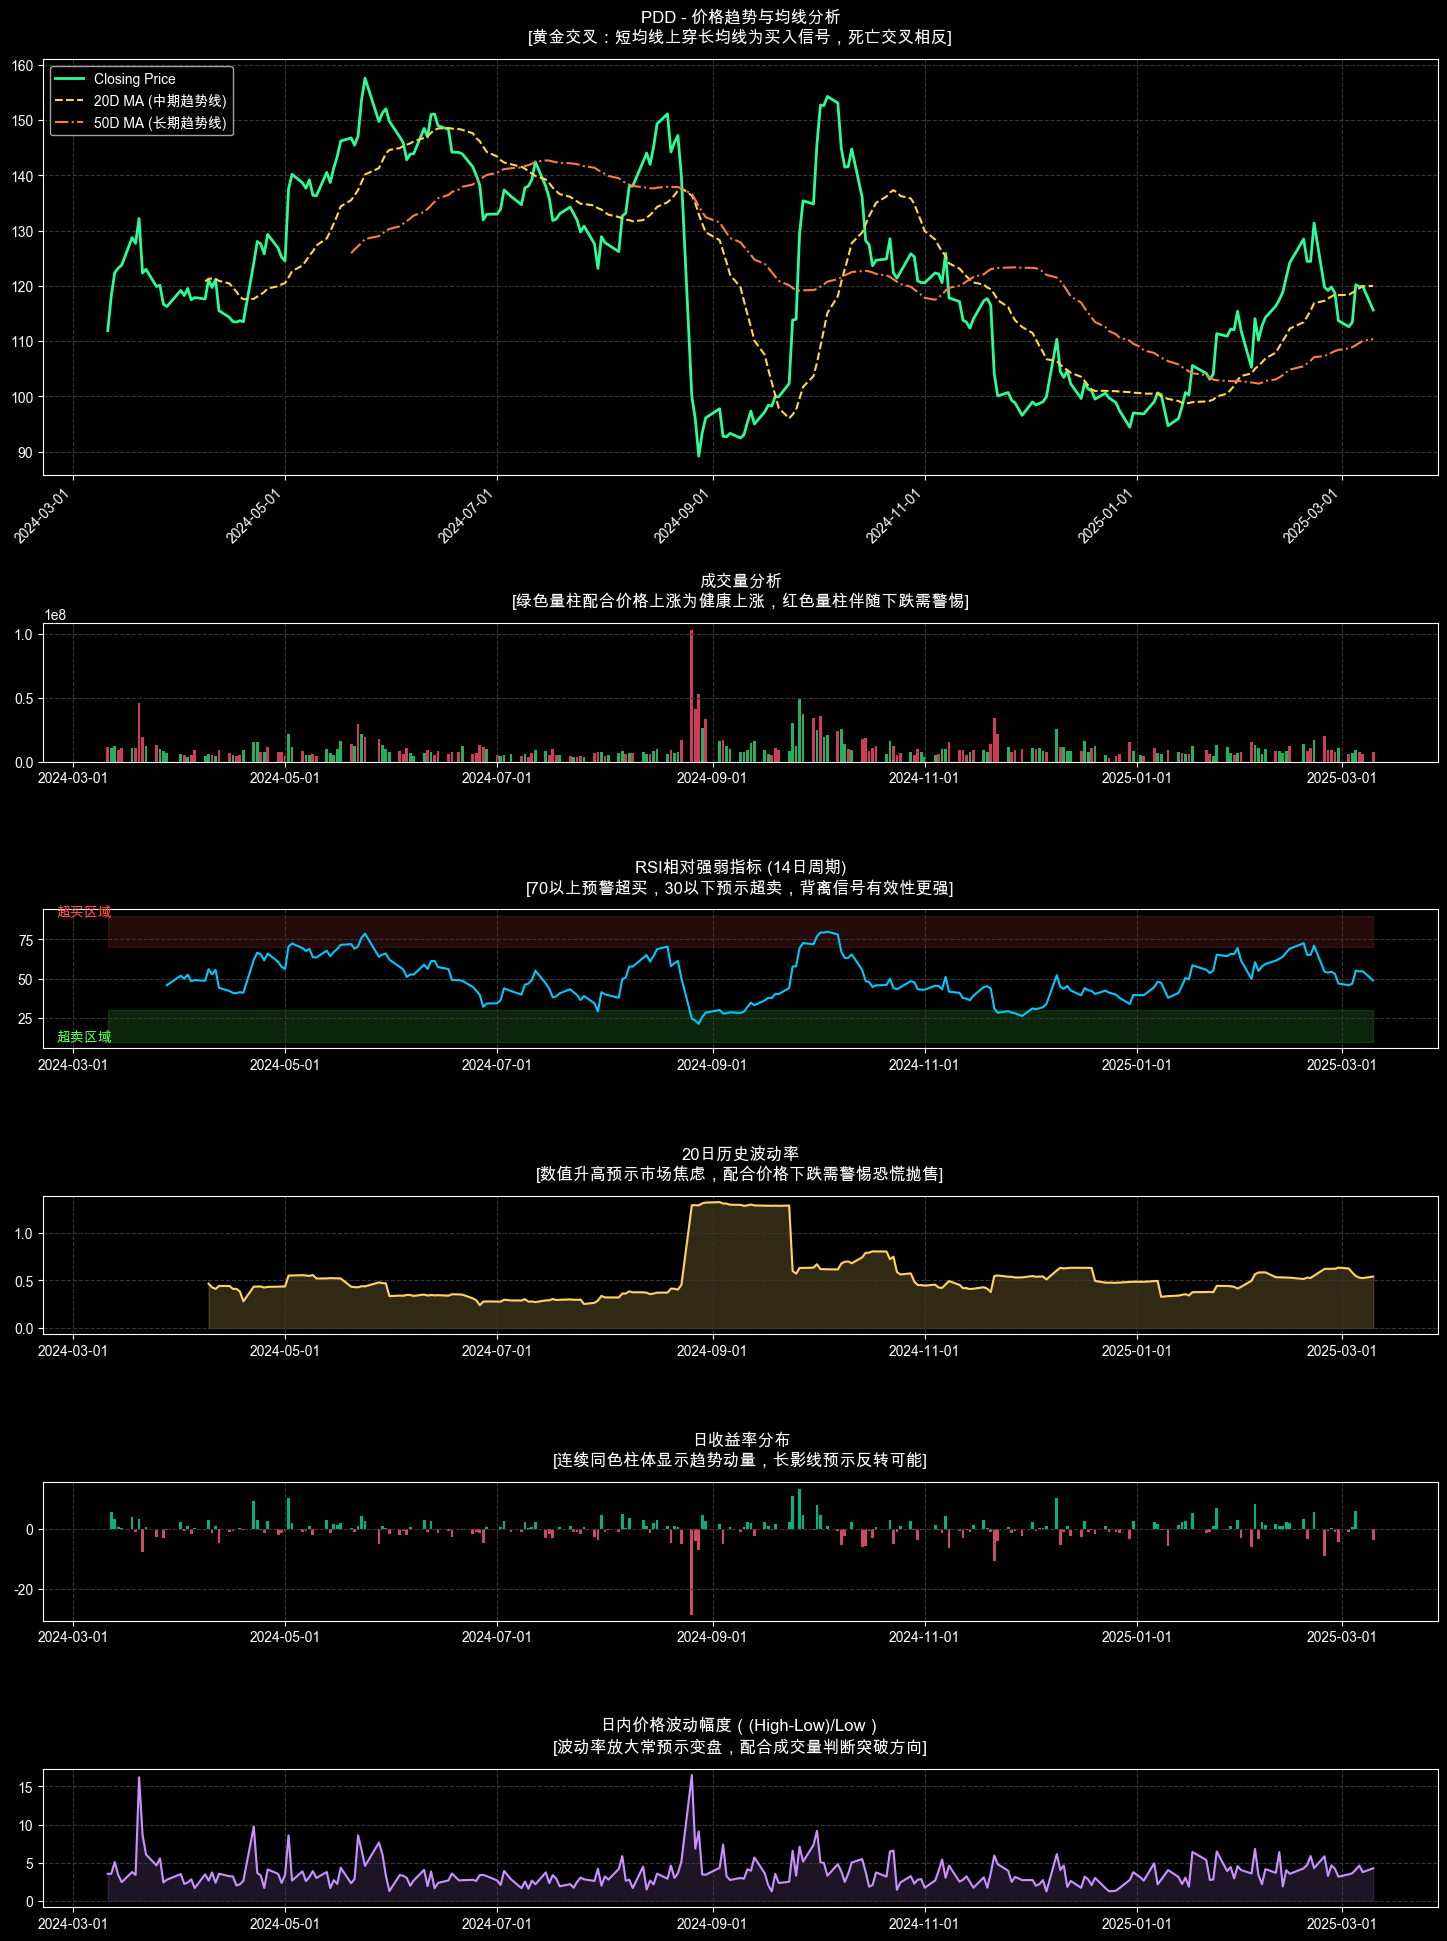

(None, None)

In [92]:
generate_report(ticker,start_date,end_date)